In [1]:
# Importing the libraries 
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import pandas as pd

# Checking the availability of CUDA on machine
print("Torch", torch.__version__, "CUDA", torch.version.cuda)
print("Device:", torch.device("cuda:0"))
print(torch.cuda.is_available())

Torch 1.0.0 CUDA 9.0
Device: cuda:0
True


In [2]:
# Loading the data taking 200 at a time
BATCH = 200
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_set = torchvision.datasets.MNIST(
    "mnist_data", transform=transform, train=True, download=True
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH)

test_set = torchvision.datasets.MNIST(
    "mnist_data", transform=transform, train=False, download=True,
)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH)

In [3]:
# I learning Pytorch using the following playlist on youtube
# A part of this code in this cell is take from those learning
# https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(28 * 28, 1024)
        self.hidden_layer1 = nn.Linear(1024, 1024)
        self.hidden_layer2 = nn.Linear(1024, 1024)
        self.hidden_layer3 = nn.Linear(1024, 1024)
        self.hidden_layer4 = nn.Linear(1024, 1024)
#         self.hidden_layer5 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 10)
        self.activation = nn.ReLU()

    def forward(self, data):
        data = data.view(-1, 28 * 28).cuda()
        self.data = data
        self.output_input_layer = self.activation(self.input_layer(data))
        self.output_1st_hidden = self.activation(
            self.hidden_layer1(self.output_input_layer)
        )
        self.output_2nd_hidden = self.activation(
            self.hidden_layer2(self.output_1st_hidden)
        )
        self.output_3rd_hidden = self.activation(
            self.hidden_layer3(self.output_2nd_hidden)
        )
        self.output_4th_hidden = self.activation(
            self.hidden_layer4(self.output_3rd_hidden)
        )
#         self.output_5th_hidden = self.activation(
#             self.hidden_layer5(self.output_4th_hidden)
#         )
        self.final_output = self.output_layer(self.output_4th_hidden)
        self.softmax_output = torch.nn.functional.log_softmax(self.final_output, dim=1)
        return self.softmax_output



In [4]:
#Training the network
neural_network = NeuralNet().cuda()
loss_function = nn.CrossEntropyLoss()
para = neural_network.parameters()
optimizer = torch.optim.Adam(para, lr=0.001)
loss_list = []
epochs = 35
for t in range(epochs):
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        outputs = neural_network(images.cuda())
        loss = loss_function(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
# For debugging purpose
#     loss_list.append(loss.data.cpu().numpy())
# For debugging purpose
# print(loss.data)
# plt.plot(range(epochs), loss_list)
# plt.show()  



In [5]:
# Testing the trained model
def test():
    correct = 0
    total = 0
    save_one = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = neural_network(images)
            _, predicted = torch.max(outputs.data.cuda(), 1)
            _ = _.cuda()
            predicted = predicted.cuda()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(correct)
    acc = (100.0 * correct / total)
    print("Accuracy:" , acc)
    return acc

In [6]:
print("Accuracy with original model")
test()

Accuracy with original model
9833
Accuracy: 98.33


98.33

In [7]:
w1 = neural_network.input_layer.weight.data
w2 = neural_network.hidden_layer1.weight.data
w3 = neural_network.hidden_layer2.weight.data
w4 = neural_network.hidden_layer3.weight.data
w5 = neural_network.hidden_layer4.weight.data
# w6 = neural_network.output_layer.weight.data

In [8]:
u1,s1,v1 = torch.svd(w1)
u2,s2,v2 = torch.svd(w2)
u3,s3,v3 = torch.svd(w3)
u4,s4,v4 = torch.svd(w4)
u5,s5,v5 = torch.svd(w5)
state_dict = neural_network.state_dict()


In [9]:
d= [10,20,50,100,200, 'full']
acc_list = []
for item in d:
    print()
    if item != 'full':
        w1_new = torch.mm(u1[:,0:item],torch.mm(s1.diag()[0:item,0:item],v1[:,0:item].t()))
        w2_new = torch.mm(u2[:,0:item],torch.mm(s2.diag()[0:item,0:item],v2[:,0:item].t()))
        w3_new = torch.mm(u3[:,0:item],torch.mm(s3.diag()[0:item,0:item],v3[:,0:item].t()))
        w4_new = torch.mm(u4[:,0:item],torch.mm(s4.diag()[0:item,0:item],v4[:,0:item].t()))
        w5_new = torch.mm(u5[:,0:item],torch.mm(s5.diag()[0:item,0:item],v5[:,0:item].t()))
    else:
        w1_new = torch.mm(u1,torch.mm(s1.diag(),v1.t()))
        w2_new = torch.mm(u2,torch.mm(s2.diag(),v2.t()))
        w3_new = torch.mm(u3,torch.mm(s3.diag(),v3.t()))
        w4_new = torch.mm(u4,torch.mm(s4.diag(),v4.t()))
        w5_new = torch.mm(u5,torch.mm(s5.diag(),v5.t()))
        
    state_dict['input_layer.weight'] = w1_new
    state_dict['hidden_layer1.weight'] = w2_new
    state_dict['hidden_layer2.weight'] = w3_new
    state_dict['hidden_layer3.weight'] = w4_new
    state_dict['hidden_layer4.weight'] = w5_new
    
    neural_network.load_state_dict(state_dict)
    print("Accuracy when d is ", item)
    acc = test()
    acc_list.append(acc)


Accuracy when d is  10
6179
Accuracy: 61.79

Accuracy when d is  20
9493
Accuracy: 94.93

Accuracy when d is  50
9829
Accuracy: 98.29

Accuracy when d is  100
9835
Accuracy: 98.35

Accuracy when d is  200
9839
Accuracy: 98.39

Accuracy when d is  full
9833
Accuracy: 98.33


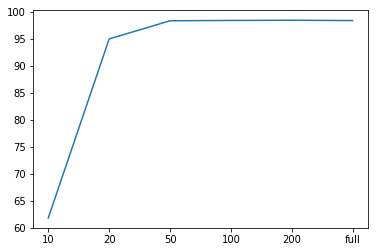

In [11]:
plt.plot(d,acc_list)

In [13]:
# setting d = 20
item = 20
w1_new = torch.mm(u1[:,0:item],torch.mm(s1.diag()[0:item,0:item],v1[:,0:item].t()))
w2_new = torch.mm(u2[:,0:item],torch.mm(s2.diag()[0:item,0:item],v2[:,0:item].t()))
w3_new = torch.mm(u3[:,0:item],torch.mm(s3.diag()[0:item,0:item],v3[:,0:item].t()))
w4_new = torch.mm(u4[:,0:item],torch.mm(s4.diag()[0:item,0:item],v4[:,0:item].t()))
w5_new = torch.mm(u5[:,0:item],torch.mm(s5.diag()[0:item,0:item],v5[:,0:item].t()))

state_dict = neural_network.state_dict()
state_dict['input_layer.weight'] = w1_new
state_dict['hidden_layer1.weight'] = w2_new
state_dict['hidden_layer2.weight'] = w3_new
state_dict['hidden_layer3.weight'] = w4_new
state_dict['hidden_layer4.weight'] = w5_new

neural_network.load_state_dict(state_dict)

In [14]:
loss_function = nn.CrossEntropyLoss()
para = neural_network.parameters()
optimizer = torch.optim.Adam(para, lr=0.001)
loss_list = []
epochs = 35
for t in range(epochs):
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        outputs = neural_network(images.cuda())
        loss = loss_function(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()

In [15]:
test()

9856
Accuracy: 98.56


98.56